## Bankruptcy Model (Non-Daily)

In [1]:
# load libraries
import pandas as pd
import numpy as np

#### Quarterly Data Processing

In [2]:
# read data & clear initial features
quarterly = pd.read_csv('quarterly.csv')
cols = ['fyearq','indfmt','consol','popsrc','datafmt','datacqtr','datafqtr',
        'curcdq','fqtr','costat','sic','tic','conm','mkvaltq']
quarterly = quarterly.drop(columns=cols)

In [4]:
# generate accounting features
quarterly['ME'] = quarterly['prccq']*quarterly['cshoq']
quarterly['BE'] = quarterly['atq'] - quarterly['ltq']
quarterly['BE'] = np.where(quarterly['BE'] < 1, 1,quarterly['BE']) # if BE is neg, set BE to $1
quarterly['ME'] = np.where(quarterly['ME'].isna(),quarterly['BE'],quarterly['ME']) # if ME is null, set to BE
quarterly['atq-adj'] = quarterly['atq'] + 0.1*(quarterly['ME'] - quarterly['BE'])
quarterly['NITA'] = quarterly['niq']/quarterly['atq-adj']
quarterly['NIMTA'] = quarterly['niq']/(quarterly['ME'] + quarterly['ltq'])
quarterly['TLTA'] = quarterly['ltq']/quarterly['atq-adj']
quarterly['TLMTA'] = quarterly['ltq']/(quarterly['ME'] + quarterly['ltq'])
quarterly['CASHMTA'] = quarterly['cheq']/quarterly['atq-adj']
quarterly['MB'] = quarterly['ME']/quarterly['BE']

# clear old features
cols = ['prccq','cshoq','atq','ltq','niq','atq-adj','ME','BE','cheq']
quarterly = quarterly.drop(columns=cols)

In [4]:
# convert date to dateime and lag 2 months
quarterly['date'] = pd.to_datetime(quarterly['datadate']).dt.to_period('M') + 2
quarterly = quarterly.drop(columns='datadate')

# duplicate data to all months
temp1, temp2 = quarterly.copy(), quarterly.copy()
temp1['date'], temp2['date'] = (temp1['date'] + 1), (temp2['date']+ 2)
quarterly = quarterly.append(temp1, ignore_index=True)
quarterly = quarterly.append(temp2, ignore_index=True)
quarterly = quarterly.sort_values(by=['gvkey','date']).reset_index(drop=True)

# clear null values
quarterly = quarterly.dropna().reset_index(drop=True)

In [5]:
# define winsorize function
def winsorize(x):
    fifth = np.percentile(x, 5)
    nintyfifth = np.percentile(x, 95)
    x = np.where(x < fifth, fifth, x)
    x = np.where(x > nintyfifth, nintyfifth, x)
    return x

# winsorize variables 
quarterly.iloc[:,1:-1] = quarterly.iloc[:,1:-1].apply(winsorize)

In [6]:
quarterly.to_csv('quarterly-new.csv',index=False)

,gvkey,NITA,NIMTA,TLTA,TLMTA,CASHMTA,MB,date
0,1000,-0.070960,-0.056169,0.693354,0.548831,0.084630,2.054797,1972-02
1,1000,-0.070960,-0.056169,0.693354,0.548831,0.084630,2.054797,1972-03
2,1000,-0.070960,-0.056169,0.693354,0.548831,0.084630,2.054797,1972-04
3,1000,-0.001788,-0.001333,0.622747,0.464214,0.097960,2.118324,1973-02
4,1000,-0.001788,-0.001333,0.622747,0.464214,0.097960,2.118324,1973-03
...,...,...,...,...,...,...,...,...
3399751,345980,-0.090776,-0.090776,0.928990,0.889005,0.602749,1.000000,2020-03
3399752,345980,-0.090776,-0.090776,0.928990,0.889005,0.602749,1.000000,2020-04
3399753,345980,-0.073770,-0.070113,1.051416,0.889005,0.602749,1.000000,2020-11
3399754,345980,-0.073770,-0.070113,1.051416,0.889005,0.602749,1.000000,2020-12


#### Monthly Data Processing

In [25]:
# read data
monthly = pd.read_csv('monthly.csv')
sp500 = pd.read_csv('sp500.csv')

# clear initial features
cols = ['conm','sic','ajexm','ajpm','iid']
monthly = monthly.drop(columns=cols)

In [26]:
# inital monthly and s&p processing then merge
monthly['prccm'] = np.where(monthly['prccm'] < 0, monthly['prccm']*-1, monthly['prccm'])
monthly['date'] = pd.to_datetime(monthly['datadate']).dt.to_period('M')
sp500['date'] = pd.to_datetime(sp500['caldt']).dt.to_period('M')
monthly = monthly.merge(sp500, on='date')
cols = ['caldt']
monthly = monthly.drop(columns=cols)
monthly = monthly.rename(columns={'trt1m':'return','prccm':'price','cshoq':'shares',
                                  'secstat':'status','sprtrn':'sp return','totval':'sp mktcap',
                                  'LPERMNO':'PERMNO','LPERMCO':'PERMCO','GVKEY':'gvkey'})

In [27]:
# merge in daily data (SIGMA and sh/o data)
daily = pd.read_csv('daily-3.csv')
daily = daily[['SHROUT','CFACSHR','PERMNO','date','SIGMA']]
monthly['datadate'] = pd.to_datetime(monthly['datadate'])
daily['date'] = pd.to_datetime(daily['date'])
monthly = monthly.merge(daily, how='left', suffixes=[None,'_d'],
                     left_on=['PERMNO','datadate'], right_on=['PERMNO','date'])

In [28]:
# generate monthly variables
monthly['return_adj'] = monthly['return']/100
monthly['shares_adj'] = (monthly['SHROUT']*1000)*monthly['CFACSHR']
monthly['EXRET'] = np.log(1 + monthly['return_adj']) - np.log(1 + monthly['sp return'])
monthly['EXRET'] = np.where(monthly['EXRET'].isna(), 0, monthly['EXRET'])
monthly['RSIZE'] = np.log((monthly['price']*monthly['shares_adj'])/(monthly['sp mktcap']))
monthly['RSIZE'] = monthly['RSIZE'].replace(-np.inf, 0)
monthly['PRICE'] = np.log(np.where(monthly['price'] > 15, 15, monthly['price']))
monthly['PRICE'] = monthly['PRICE'].replace(-np.inf, 0)

C:\Users\shanc\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\shanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


#### Merge Monthly with Quarterly & Bankrupcy Data

In [29]:
quarterly = pd.read_csv('quarterly-new.csv')
bankrupt = pd.read_csv('bankrupt.csv')

In [30]:
# lite process, merge, and clean
quarterly['date'] = pd.to_datetime(quarterly['date']).dt.to_period('M')
bankrupt['date'] = pd.to_datetime(bankrupt['datadate']).dt.to_period('M')
data = quarterly.merge(monthly, on=['gvkey','date'])
data = data.merge(bankrupt[['gvkey','date','dlrsn']], on=['gvkey','date'])
cols = ['gvkey','date','NITA','NIMTA','TLTA','TLMTA','CASHMTA','MB','EXRET','RSIZE',
        'PRICE','SIGMA','PERMNO','PERMCO']
d = data[cols]

#### Add Audit Data and Additional Identifiers

In [61]:
m2 = pd.read_csv('monthly-new.csv')
m3 = pd.read_csv('monthly-merge.csv')
aa = pd.read_csv('audit analytics.csv')

C:\Users\shanc\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [112]:
# merge on permno and date
m = m2.merge(m3, left_on=['PERMNO','date'], right_on=['LPERMNO','datadate'])

# remove dlrsn duplicates (remove to get old df)
m['dlrsn'] = np.where(m['GVKEY'] != m['GVKEY'].shift(-1), m['dlrsn'], 0)

# exlude firm-months
m['date'] = pd.to_datetime(m['date']).dt.to_period('M')
m = m[m['SHRCD'].isin([10,11])]
m = m[m['EXCHCD'].isin([1,2,3,4,10,13,16,17])]
m = m[m['SHRCLS'].isin(['A',np.nan])]
m = m[~m['sic'].between(6000,6999)]

# merge desired identifiers/features
cols = ['PERMNO','date','GVKEY','LPERMCO','cusip','cik','dlrsn']#,'sic','dldte']
d2 = d.merge(m[cols], on=['PERMNO','date'])

# update dataframe & develop target features
d2['DLRSN B'] = np.where(d2['dlrsn'] == 2,1,0)
d2['DLRSN L'] = np.where(d2['dlrsn'] == 3,1,0)
d2 = d2.drop(columns=['LPERMCO','dlrsn','GVKEY'])
d2 = d2.rename(columns={'PERMNO':'permno','PERMCO':'permco'})

# merge in audit analytics data
aa2 = aa.rename(columns={'COMPANY_FKEY':'cik','FILE_DATE':'filedate'})
aa2['filemonth'] = pd.to_datetime(aa2['filedate'],format='%Y%m%d').dt.to_period('M')
d2 = d2.merge(aa2, left_on=['cik','date'], right_on=['cik','filemonth'], how='left')
d2['AA B'] = np.where(d2['filemonth'].isna(),0,1)
d2['FAILURE DLRSN'] = np.where((d2['DLRSN B'] == 1)|(d2['DLRSN L'] == 1),1,0)
d2['BNKRPT'] = np.where((d2['DLRSN B'] == 1)|(d2['AA B'] == 1),1,0)
d2['FAILURE'] = np.where((d2['DLRSN B'] == 1)|(d2['DLRSN L'] == 1)|(d2['AA B'] == 1),1,0)
d2 = d2.drop(columns=['BANKRUPTCY_TYPE','BANK_END_DATE','BANK_BEGIN_DATE','filedate','filemonth'])

#### Save and Output Final Dataset

In [118]:
d2.to_csv('data-final.csv', index=False)

In [117]:
d2.describe().T

,count,mean,std,min,25%,50%,75%,max
gvkey,1606116.0,32248.379450,47998.401387,1000.000000,6097.000000,11124.000000,28648.000000,3.321150e+05
NITA,1606116.0,-0.007273,0.053103,-0.245683,-0.008595,0.008110,0.018807,4.569294e-02
NIMTA,1606116.0,-0.002847,0.029779,-0.113816,-0.006344,0.006080,0.012504,3.256021e-02
TLTA,1606116.0,0.474169,0.240945,0.059625,0.287220,0.476553,0.635646,1.242966e+00
TLMTA,1606116.0,0.381685,0.243584,0.025577,0.169555,0.357832,0.570216,8.890049e-01
CASHMTA,1606116.0,0.139304,0.165561,0.000839,0.019986,0.067152,0.197493,6.027492e-01
MB,1606116.0,2.995813,3.367355,0.439465,1.030953,1.790164,3.315005,1.509530e+01
EXRET,1606116.0,-0.009512,0.170605,-5.086846,-0.077136,-0.005628,0.062333,5.765262e+00
RSIZE,1569507.0,-3.386754,2.592574,-22.746434,-5.079409,-3.418244,-1.680900,7.435575e+00
PRICE,1605409.0,1.982524,1.032728,-4.556380,1.531476,2.525729,2.708050,2.708050e+00


In [113]:
targets = pd.DataFrame()
targets['DLRSN B'] = d2['DLRSN B'].value_counts()
targets['DLRSN L'] = d2['DLRSN L'].value_counts()
targets['AA B'] = d2['AA B'].value_counts()
targets['FAILURE DLRSN'] = d2['FAILURE DLRSN'].value_counts()
targets['BNKRPT'] = d2['BNKRPT'].value_counts()
targets['FAILURE'] = d2['FAILURE'].value_counts()
targets = targets.rename(index={0:'False', 1:'True'})
targets

,DLRSN B,DLRSN L,AA B,FAILURE DLRSN,BNKRPT,FAILURE
False,1605639,1605803,1606013,1605326,1605542,1605234
True,477,313,103,790,574,882


In [114]:
d2['date'].unique().max(), d2['date'].unique().min()

(Period('2019-12', 'M'), Period('1970-03', 'M'))

In [115]:
c = d2.groupby(by=['date']).count()
s = d2.groupby(by=['date']).sum()

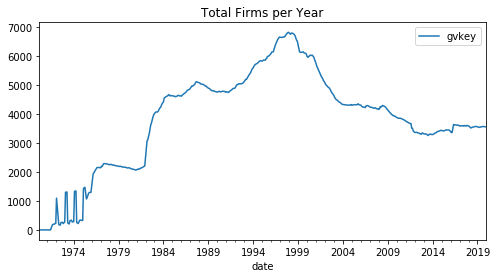

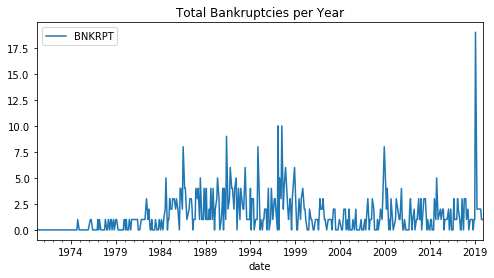

In [116]:
c[['gvkey']].plot(figsize=(8,4), title='Total Firms per Year')
s[['BNKRPT']].plot(figsize=(8,4), title='Total Bankruptcies per Year')